In [22]:
%load_ext autoreload
%autoreload 2
import os
import sys
import shutil
import argparse
import time
import json
from datetime import datetime
from collections import defaultdict
from itertools import islice
import pickle
import copy
import numpy as np
import cv2
from easydict import EasyDict
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
from tensorboardX import SummaryWriter

from mvn.models.triangulation import  VolumetricTriangulationNet
from mvn.models.volumetric_temporal import VolumetricTemporalAdaINNet
from mvn.models.v2v import AdaIN, V2VModel, V2VModel_v2, V2VModel_conf, Basic3DBlock, Res3DBlock, Upsample3DBlock, Pool3DBlock, EncoderDecorder
from mvn.models import v2v
from mvn.models.loss import KeypointsMSELoss, KeypointsMSESmoothLoss, KeypointsMAELoss, KeypointsL2Loss, VolumetricCELoss
from mvn.models import pose_hrnet, pose_resnet
from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.datasets.human36m import Human36MTemporalDataset, Human36MMultiViewDataset
from mvn.datasets import utils as dataset_utils

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import volumetric
from mvn.utils import op
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy

from tqdm import tqdm_notebook

from torch.nn.utils.rnn import pack_padded_sequence
from pytorch_convolutional_rnn.convolutional_rnn import Conv2dLSTM, Conv2dPeepholeLSTM

from train import setup_human36m_dataloaders

device = torch.cuda.current_device()

def get_n(m):
    s = 0
    for param in m.parameters():
        s+=param.nelement()
    print (m.__class__, s//1024)    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of mvn.models.v2v failed: Traceback (most recent call last):
  File "/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  F

In [61]:
s = '123'
s.split('_')

['123']

In [57]:
s.append()dd

TypeError: append() missing 1 required positional argument: 'module'

# Backbone

In [ ]:
backbone = pose_resnet.get_pose_net(config.model.backbone,
                                     device=device,
                                     strict=True)

# FeaturesEncoder_Features2D

In [66]:
class FeaturesEncoder_Features2D(nn.Module):
    """docstring for FeaturesEncoder_Features2D"""
    def __init__(self, input_features_dim, output_features_dim, C = 2, multiplier=128, n_groups=32, normalization_type='batch_norm'):
        super().__init__()
        self.output_features_dim = output_features_dim
        self.input_features_dim = input_features_dim
        self.C = C
        self.multiplier = multiplier
        
        if self.C == 0:
            self.features = nn.Sequential()
        else:    
            self.features=nn.Sequential(nn.Conv2d(input_features_dim, 
                                                  self.C * self.multiplier, 
                                                  kernel_size=3, 
                                                  padding=1),
                                          get_normalization_2d(normalization_type,
                                                               self.C * self.multiplier, n_groups=n_groups),
                                          nn.ReLU(),
                                          nn.Conv2d(self.C * self.multiplier, 
                                                    self.C * self.multiplier//2, 
                                                    kernel_size=3, 
                                                    padding=1),
                                          get_normalization_2d(normalization_type,
                                                               self.C * self.multiplier//2, n_groups=n_groups),
                                          nn.ReLU(),
                                          nn.Conv2d(self.C * self.multiplier//2,
                                                    self.C * self.multiplier//4, 
                                                    kernel_size=3, 
                                                    padding=1),
                                          get_normalization_2d(normalization_type,
                                                               self.C * self.multiplier//4, n_groups=n_groups),
                                          nn.ReLU(),
                                          nn.Conv2d(self.C * self.multiplier//4,
                                                    self.C * self.multiplier//4, kernel_size=1),
                                          get_normalization_2d(normalization_type,
                                                               self.C * self.multiplier//4, n_groups=n_groups),
                                          nn.ReLU(),
                                          nn.Conv2d(self.C * self.multiplier//4, output_features_dim, kernel_size=1)
                                        )
        
    def forward(self, x):
        # [2048, 12, 12]
        batch_size = x.shape[0]
        x = self.features(x)
        return x     

In [68]:
x = torch.randn(1,256, 96,96)
m = FeaturesEncoder_Features2D(256,32)
m(x).shape

torch.Size([1, 32, 96, 96])

# FeaturesEncoder_Bottleneck2D

In [71]:
def get_normalization_2d(normalization_type, out_planes, n_groups):
    if normalization_type ==  'batch_norm':
        return nn.BatchNorm2d(out_planes)
    elif normalization_type == 'group_norm':
        return nn.GroupNorm(n_groups, out_planes)
    else:
        raise RuntimeError('{} is unknown normalization_type for this model'.format(normalization_type))   
        
class FeaturesEncoder_Bottleneck2D(nn.Module):
    """docstring for FeaturesEncoder_Bottleneck2D"""
    def __init__(self,
                 output_features_dim,
                 input_channels,
                 C=2, 
                 multiplier=128, 
                 n_groups=32, 
                 normalization_type='batch_norm', 
                 upscale=False, 
                 input_size=None, 
                 target_size=None,
                 upscale_kernel_size=2):
        
        super().__init__()
        self.output_features_dim = output_features_dim
        self.C = C
        self.multiplier = multiplier
        self.upscale = upscale
        self.upscale_kernel_size = upscale_kernel_size
        self.normalization_type = normalization_type
        self.n_groups = n_groups
        modules=[]
            
        size = input_size 
        in_channels = input_channels
        out_channels = input_channels
        i = 1
        while True:
            size *= kernel_size
            if size > target_size:
                break
            out_channels = self.C * self.multiplier//i
            modules.append(self._get_upscale_block(in_channels, out_channels))
            if i < 4:
                i*=2
            in_channels = out_channels
        
        self.features = nn.Sequential(*modules)
        self.final_upscale = nn.UpsamplingBilinear2d(size=target_size)
        self.final_layer = nn.Conv2d(out_channels, output_features_dim, kernel_size=1)
    
    def _get_upscale_block(self, in_channels, out_channels):
        
        block = nn.Sequential(nn.Conv2d(in_channels, 
                                        out_channels, 
                                        kernel_size=3, 
                                        padding=1),
                                        get_normalization_2d(self.normalization_type, 
                                                             out_channels, 
                                                             n_groups=self.n_groups))
        if self.upscale:
            block.add_module('upscale',nn.ConvTranspose2d(out_channels, 
                                                          out_channels, 
                                                          kernel_size=self.upscale_kernel_size, 
                                                          stride=self.upscale_kernel_size))
        return block
    
    def forward(self, x):
        # [2048, 12, 12]
        batch_size = x.shape[0]
        x = self.features(x)
        x =  self.final_upscale(x)
        x = self.final_layer(x)
        return x          

In [73]:
x = torch.randn(3,2048, 12, 12)
model = FeaturesEncoder_Bottleneck2D(output_features_dim=32,
                                     input_channels=2048,
                                     C=2, 
                                     multiplier=128, 
                                     n_groups=32, 
                                     normalization_type='group_norm', 
                                     upscale=False, 
                                     input_size=12, 
                                     target_size=96,
                                     upscale_kernel_size=2)
model(x).shape

torch.Size([3, 32, 96, 96])

# Seq2VecCNN2D

In [30]:
class Seq2VecCNN2D(nn.Module):
    """docstring for Seq2VecCNN2D"""
    def __init__(self, 
                 input_features_dim, 
                 output_features_dim=32, 
                 intermediate_channel = 128,
                 normalization_type='group_norm',
                 kernel_size = 3,
                 dt = 8):
        
        super(Seq2VecCNN2D, self).__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.normalization_type = normalization_type
        self.dt = dt
        
        self.first_block = nn.Conv3d(input_features_dim, 
                                      intermediate_channel,
                                      kernel_size=(1,kernel_size,kernel_size))

        l = dt
        blocks =  []
        while l >= kernel_size:
            l = l - kernel_size + 1
            
            blocks.append(nn.Conv3d(intermediate_channel, 
                                 intermediate_channel,
                                 kernel_size = kernel_size,
                                 padding = (0,1,1)))
            blocks.append(nn.GroupNorm(32, intermediate_channel))
            blocks.append(Res3DBlock(intermediate_channel, 
                                     intermediate_channel,
                                     normalization_type=normalization_type,
                                     kernel_size = kernel_size,
                                     padding = 1))
            
        self.blocks = nn.Sequential(*blocks)    
        self.final_block = nn.Conv3d(intermediate_channel, 
                                      output_features_dim,
                                      kernel_size=(l,1,1),
                                      padding=(0,1,1))
        
    def forward(self, x, device='cuda:0'):
        # [batch_size, channels, dt,96.96]
        x  = self.first_block(x)
        x  = self.blocks(x)
        x  = self.final_block(x)
        
        return x#[:,:,0,...]


In [31]:
model = Seq2VecCNN2D(256)
model(torch.randn(3,256,8,96,96)).shape

torch.Size([3, 32, 96, 96])

# Backbone loss


In [51]:
def generate_target(joints, 
                    joints_vis=None, 
                    num_joints=16, 
                    target_type='gaussian', 
                    sigma=3, 
                    heatmap_size=[96,96],
                    image_size=[384,384]):
        '''
        :param joints:  [num_joints, 3]
        :param joints_vis: [num_joints, 3]
        :return: target, target_weight(1: visible, 0: invisible)
        '''
        target_weight = np.ones((num_joints, 1), dtype=np.float32)
        heatmap_size = np.array(heatmap_size)
        image_size = np.array(image_size)
        if joints_vis is not None:
            target_weight[:, 0] = joints_vis[:, 0]

        if target_type == 'gaussian':
            target = np.zeros((num_joints,
                               heatmap_size[1],
                               heatmap_size[0]),
                              dtype=np.float32)

            tmp_size = sigma * 3

            for joint_id in range(num_joints):
                feat_stride = image_size / heatmap_size
                mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
                mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
                # Check that any part of the gaussian is in-bounds
                ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
                br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
                if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] \
                        or br[0] < 0 or br[1] < 0:
                    # If not, just return the image as is
                    target_weight[joint_id] = 0
                    continue

                # # Generate gaussian
                size = 2 * tmp_size + 1
                x = np.arange(0, size, 1, np.float32)
                y = x[:, np.newaxis]
                x0 = y0 = size // 2
                # The gaussian is not normalized, we want the center value to equal 1
                g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

                # Usable gaussian range
                g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
                g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]
                # Image range
                img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
                img_y = max(0, ul[1]), min(br[1], heatmap_size[1])

                v = target_weight[joint_id]
                if v > 0.5:
                    target[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
                        g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

#         if use_different_joints_weight:
#             target_weight = np.multiply(target_weight, joints_weight)

        return target, target_weight
    
    

In [39]:
for batch in train_loader:
    break
    
images_batch, keypoints_3d_batch_gt, keypoints_3d_validity_batch_gt, proj_matricies_batch = dataset_utils.prepare_batch(batch, device)


In [55]:
config.model.backbone.return_bottleneck = True
backbone = pose_resnet.get_pose_net(config.model.backbone,
                                     device='cuda:0',
                                     strict=True).cuda()

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone


In [56]:
image_shape = images_batch.shape[-2:]
images_batch = images_batch.view(-1, 3, *image_shape).cuda()
pivot_heatmaps, pivot_features, pivot_alg_confidences, pivot_vol_confidences, pivot_bottleneck = backbone(images_batch)

In [57]:
pivot_bottleneck.shape

torch.Size([1, 2048, 12, 12])

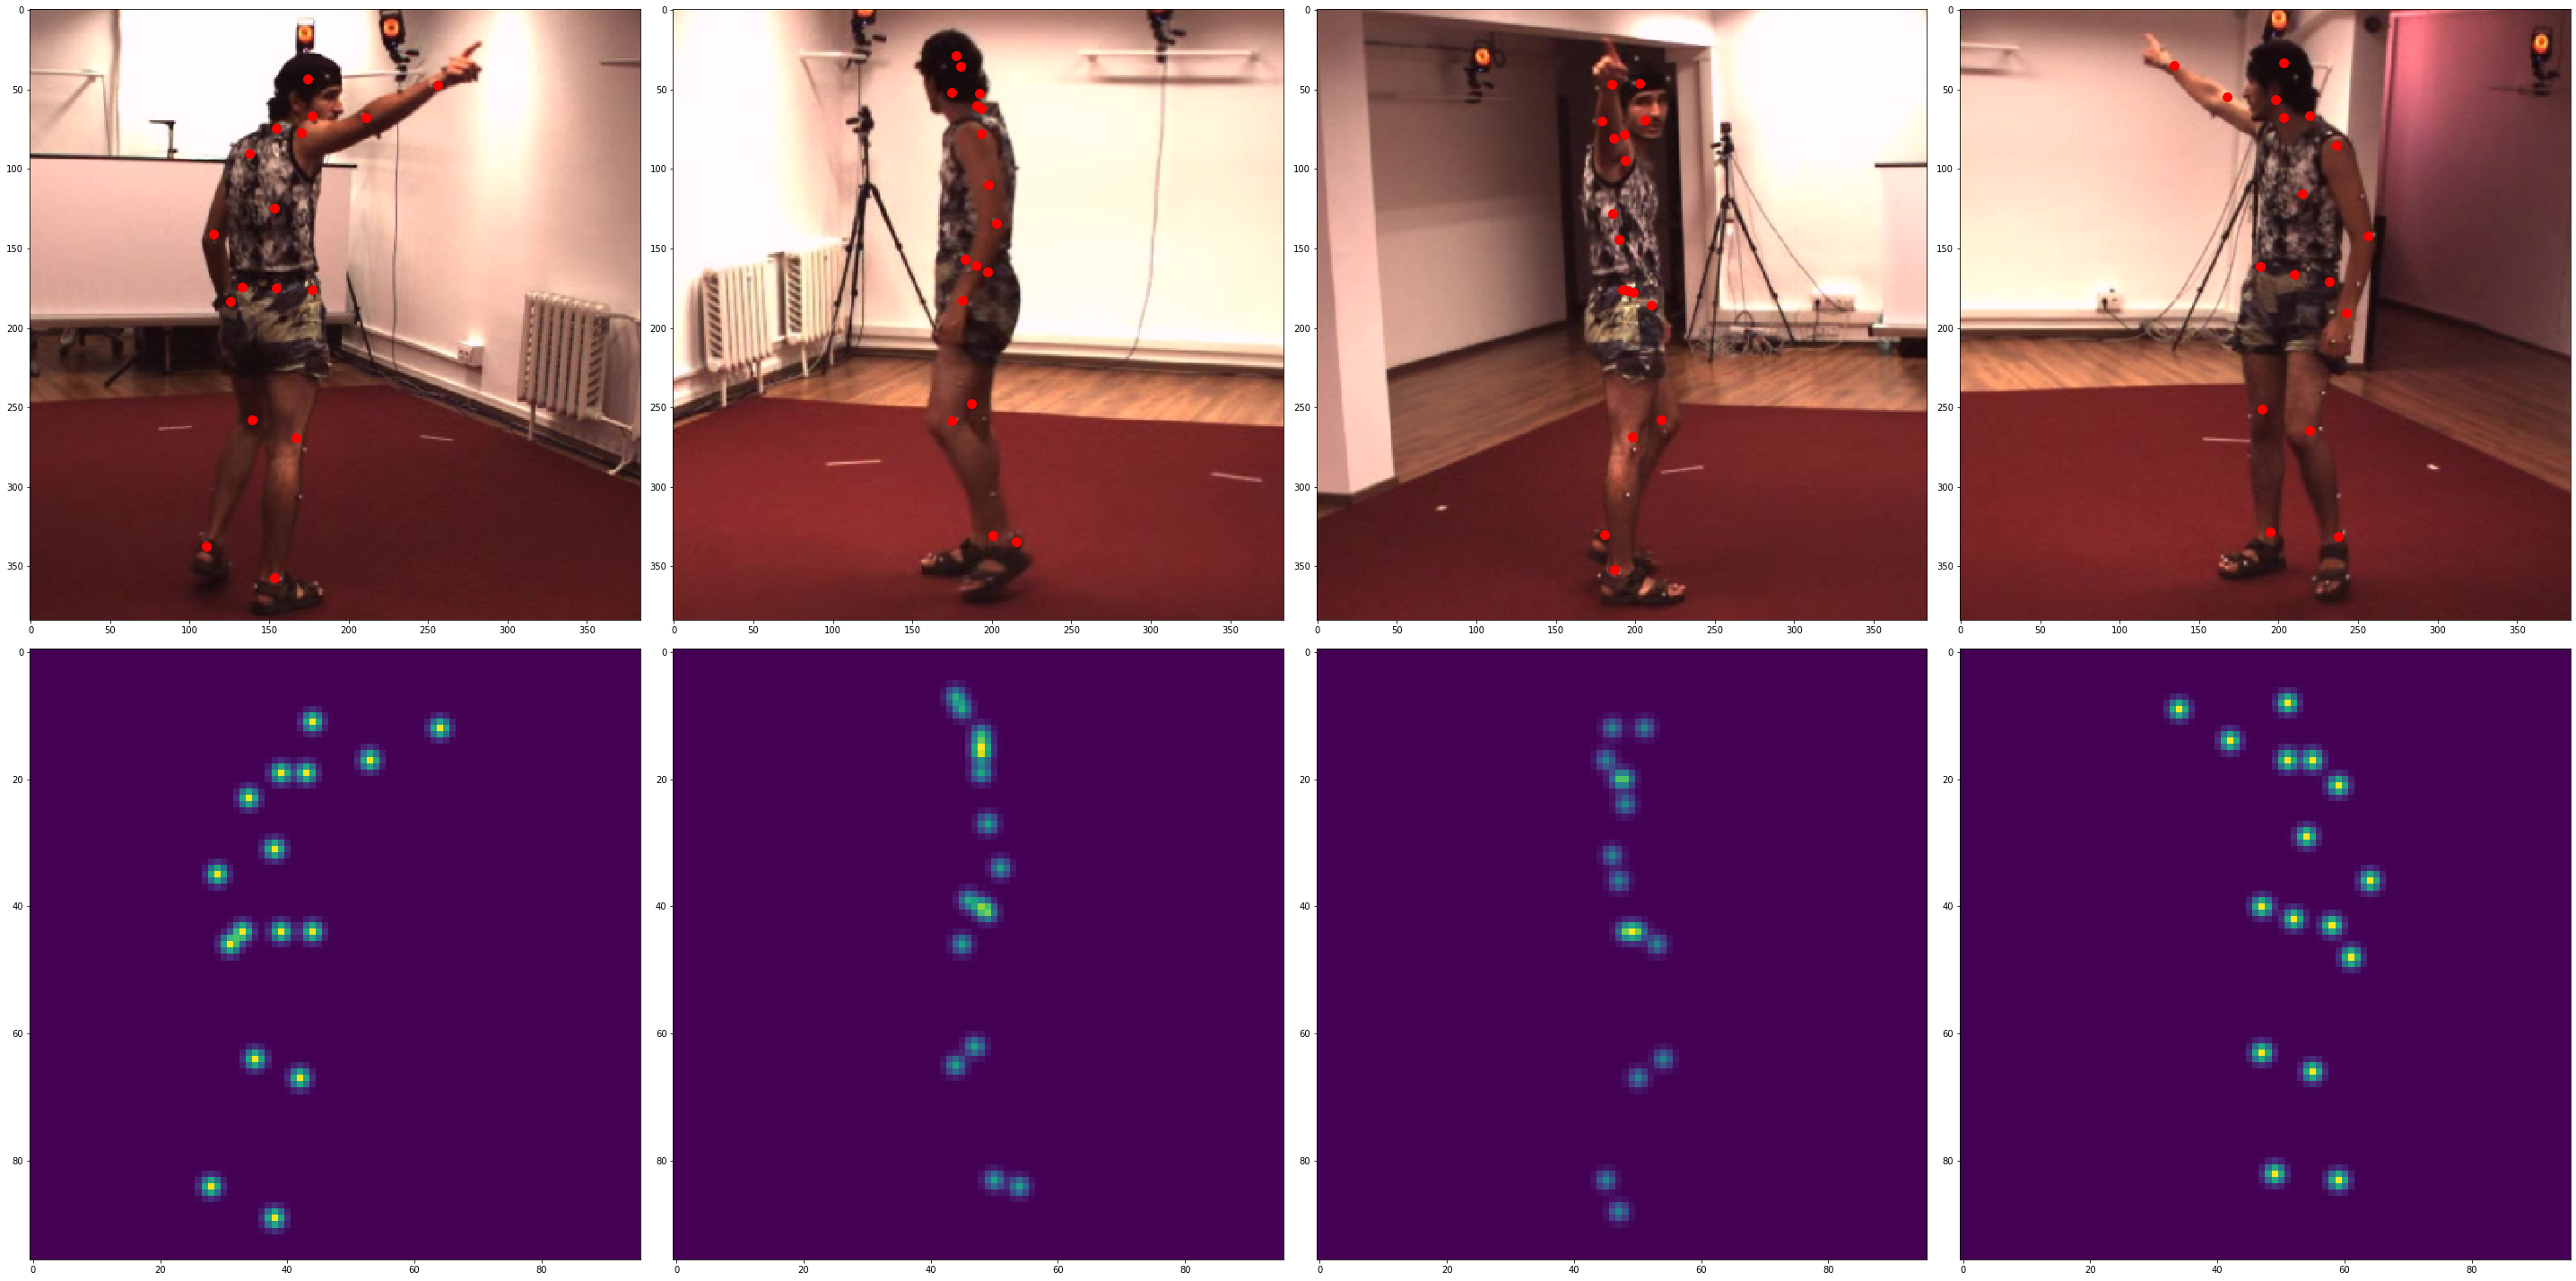

In [54]:
batch_size, n_views = images_batch.shape[:2]
batch_index = 0
fig, axes = plt.subplots(nrows=2 , ncols=n_views, figsize = (n_views*10, 20))

for view_index in range(n_views):
    proj_matrix = proj_matricies_batch[batch_index, view_index]
    keypoints_3d = keypoints_3d_batch_gt[batch_index]

    images = image_batch_to_numpy(images_batch[batch_index])
    images = denormalize_image(images).astype(np.uint8)
    images = images[..., ::-1]  # bgr -> rgb
    image = images[view_index]

    keypoints_2d_wrt_new = project_3d_points_to_image_plane_without_distortion(proj_matrix, keypoints_3d)
    keypoints_2d_wrt_new = keypoints_2d_wrt_new.cpu().numpy()
    
    target,_ = generate_target(keypoints_2d_wrt_new, sigma = 1)
    
    axes[0,view_index].imshow(image)
    axes[1,view_index].imshow(target.sum(0))
    axes[0,view_index].scatter(keypoints_2d_wrt_new[:, 0], keypoints_2d_wrt_new[:, 1], s=100, c='red')
plt.tight_layout()

In [62]:
keypoints_3d_numpy = keypoints_3d.cpu().numpy()

In [70]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import colorlover as cl

init_notebook_mode(connected=False)  
color = cl.scales['10']['div']['RdYlBu'][0]
plotly_data = []

x = keypoints_3d_numpy[:,0]
y = keypoints_3d_numpy[:,1]
z = keypoints_3d_numpy[:,2]

#             name = 'digit: {}'.format(digit),
#             text = 'digit: {}'.format(digit),

trace = dict(x = x,
            y = y,
            z = z,
            type = "scatter3d",    
            mode = 'markers',
            marker = dict(size=5,
                          color=color,
                          line=dict(width=0)))

plotly_data.append( trace )
fig = go.Figure(data=plotly_data)
iplot(fig, show_link = False)

# Seq2VecRNN2D

In [2]:
# in_channels = 32
# net = Conv2dLSTM(in_channels=in_channels,  # Corresponds to input size
#                    out_channels=32,  # Corresponds to hidden size
#                    kernel_size=3,  # Int or List[int]
#                    num_layers=2,
#                    bidirectional=True,
#                    dilation=1, stride=1, dropout=0.5,
#                    batch_first=True)
# length = 8
# batchsize = 2
# shape = (96, 96)
# x = torch.randn(batchsize, length, in_channels, *shape)
# h = None
# y, h = net(x, h)
# y.shape

In [4]:
class Seq2VecRNN2D(nn.Module):
    """docstring for Seq2VecRNN"""
    def __init__(self, input_features_dim, output_features_dim=64, hidden_dim = 64):
        super(Seq2VecRNN2D, self).__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.hidden_dim = hidden_dim
        self.bidirectional = True
        
        self.lstm = Conv2dLSTM(in_channels=input_features_dim,  # Corresponds to input size
                                   out_channels=hidden_dim,  # Corresponds to hidden size
                                   kernel_size=3,  # Int or List[int]
                                   num_layers=2,
                                   bidirectional=self.bidirectional,
                                   dilation=1, 
                                   stride=1,
                                   dropout=0.2,
                                   batch_first=True)

        self.output_layer = nn.Conv2d(2*self.hidden_dim if self.bidirectional else self.hidden_dim,
                                      self.output_features_dim, kernel_size=1)
        self.activation = nn.ReLU()
        
    def forward(self, features, eps = 1e-3, device='cuda:0'):
        # [bathc_size, dt, feature_shape]
        batch_size = features.shape[0]
        output, _ = self.lstm(features, None)
        output = output[:,-1,...]
        output = self.activation(self.output_layer(output))
        return output

In [6]:
model = Seq2VecRNN2D(input_features_dim = 256,
              output_features_dim =  32,
              hidden_dim = 256).cuda()

In [21]:
m1 = torch.cuda.memory_allocated()

In [8]:
out = model(torch.randn(1,7,256,96,96).cuda())

In [25]:
m2 = torch.cuda.memory_allocated()

In [26]:
m2 - m1

3506254848

In [9]:
!nvidia-smi

Thu Feb  6 15:19:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.66       Driver Version: 410.66       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 52%   62C    P2    62W / 280W |   4924MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 67%   69C    P2   108W / 280W |  10715MiB / 11178MiB |     59%      Default |
+-------------------------------+----------------------+----------------------+
        

# V2V configured

In [18]:
config_path = './experiments/human36m/train/human36m_vol_temporal_adain.yaml'
config = cfg.load_config(config_path)

normalization_type = 'group_norm'
default_normalization_type = 'group_norm'

adain_dict = {}
skip_block_type = 'Res3DBlock'

downsampling_config = config.model.v2v_configuration.downsampling
bottleneck_config = config.model.v2v_configuration.bottleneck
upsampling_config = config.model.v2v_configuration.upsampling

downsampling_dict = nn.ModuleDict()
upsampling_dict = nn.ModuleDict()
bottleneck_dict = nn.ModuleDict()

downsampling_blocks_numerator = {'Res3DBlock':0, 'Pool3DBlock':0, 'Upsample3DBlock':0}
upsampling_blocks_numerator = {'Res3DBlock':0, 'Pool3DBlock':0, 'Upsample3DBlock':0}
bottleneck_blocks_numerator = {'Res3DBlock':0, 'Pool3DBlock':0, 'Upsample3DBlock':0}

modules_requires_normalization = ['Res3DBlock', 'Upsample3DBlock']

assert len(upsampling_config) == len(downsampling_config)

def append_module(modules_dict, module_config, blocks_numerator):
    
    module_type = module_config['module_type']
    module_adain = module_config['adain']
    module_number = str(blocks_numerator[module_type])
    blocks_numerator[module_type] += 1
    
    module_normalization = normalization_type if module_adain else default_normalization_type 
    model_params = module_config['params'] + [module_normalization] if \
                   module_type in modules_requires_normalization else module_config['params']

    module = getattr(v2v, module_config['module_type'])(*model_params)
    name = ''.join((module_type, '_', module_number))
    modules_dict[name] = module

for i, module_config in enumerate(downsampling_config):
    
    append_module(downsampling_dict, module_config, downsampling_blocks_numerator)
    module_type = module_config['module_type']
    module_number = str(downsampling_blocks_numerator[module_type])
    if module_type == 'Res3DBlock':
        # add skip-connection
        in_planes = module_config['params'][-1]
        out_planes = upsampling_config[-i-1]['params'][0]
        skip_con_block = getattr(v2v, skip_block_type)(in_planes, 
                                                       out_planes, 
                                                       normalization_type=default_normalization_type)
        name = ''.join(('skip', '_', module_type, '_', module_number))
        downsampling_dict[name] = skip_con_block
        
for i, module_config in enumerate(bottleneck_config):  
    append_module(bottleneck_dict, module_config, bottleneck_blocks_numerator)
    
for i, module_config in enumerate(upsampling_config):  
    append_module(upsampling_dict, module_config, upsampling_blocks_numerator)    

### Dict

In [21]:
%%time
x = torch.randn(1,128,32,32,32)

skip_connections = []
for name, module in downsampling_dict.items():
    name_list = name.split('_')
    if name_list[0] == 'skip':
        skip_connections.append(module(x))
    else:
        x = module(x)

for name, module in bottleneck_dict.items():
    x = module(x)
print ('Bn', x.shape)        

skip_number = -1    
for name, module in upsampling_dict.items():
    x = module(x)
    if name == 'Res3DBlock':
        x = x + skip_connections[skip_number]
        skip_number -= 1
print ('Us', x.shape)        
        

Bn torch.Size([1, 256, 4, 4, 4])
Us torch.Size([1, 128, 32, 32, 32])
CPU times: user 13.8 s, sys: 1.37 s, total: 15.2 s
Wall time: 8.27 s


# Seq2VecCNN

In [81]:
class Slice(nn.Module):
    def __init__(self, shift):
        super(Slice, self).__init__()
        self.shift = shift
    def forward(self,x):
        return x[:, :, self.shift : x.shape[2] - self.shift]

class Res1DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, n_groups = 32, kernel_size=3):
        
        super(Res1DBlock, self).__init__()
        pad = kernel_size // 2 if kernel_size > 1 else 0
        self.res_branch = nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, padding=pad),
            nn.GroupNorm(n_groups, out_planes),
            nn.ReLU(True),
            nn.Conv1d(out_planes, out_planes, kernel_size=kernel_size),
            nn.GroupNorm(n_groups, out_planes)
        )

        if in_planes == out_planes:
            self.skip_con = Slice(kernel_size // 2)
        else:
            self.skip_con = nn.Sequential(
                Slice(kernel_size // 2),
                nn.Conv1d(in_planes, out_planes, kernel_size=1),
                nn.GroupNorm(n_groups, out_planes)
            )

    def forward(self, x):
        res = self.res_branch(x)
        skip = self.skip_con(x)
        print (x.shape, skip.shape)
        return F.relu(res + skip, True)

In [82]:

class Seq2VecCNN(nn.Module):
    """docstring for Seq2VecCNN"""
    def __init__(self, 
                 input_features_dim, 
                 output_features_dim=1024, 
                 intermediate_channels=512, 
                 dt = 8,
                 kernel_size = 3):
        
        super(Seq2VecCNN, self).__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.intermediate_channels = intermediate_channels
        
        self.first_block = Res1DBlock(input_features_dim, 
                                      intermediate_channels,
                                      kernel_size=1)
        
        
        l = dt
        blocks =  []
        while True:
            l = l - kernel_size + 1
            if l < kernel_size:
                break
            print (l)    
            blocks.append(Res1DBlock(intermediate_channels, 
                                     intermediate_channels, 
                                     kernel_size = kernel_size))
        
        self.blocks = nn.Sequential(*blocks)    
        self.final_block = nn.Conv1d(intermediate_channels, 
                                      output_features_dim,
                                      kernel_size=l)
        
    def forward(self, x, device='cuda:0'):
        # [batch_size, dt, feature_shape]
        x = x.transpose(1,2) # [batch_size, dt, feature_shape] -> [batch_size, feature_shape, dt]
        x  = self.first_block(x)
        x  = self.blocks(x)
        print (x.shape)
        x  = self.final_block(x)
        
        return x[...,0]

In [83]:
dt = 7
model = Seq2VecCNN(128, dt = dt, kernel_size=3)
model(torch.randn(4,dt,128)).shape

5
3
torch.Size([4, 128, 7]) torch.Size([4, 512, 7])
torch.Size([4, 512, 7]) torch.Size([4, 512, 5])
torch.Size([4, 512, 5]) torch.Size([4, 512, 3])
torch.Size([4, 512, 3])


torch.Size([4, 1024])

# AdaIN

In [2]:
adain = AdaIN()

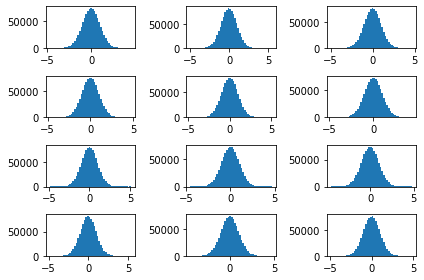

after adain


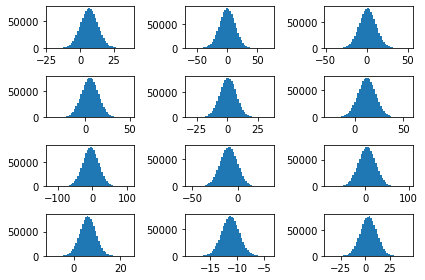

In [14]:
batch_size, C, N = 4,3,100
x = torch.randn(batch_size, C, N,N,N)
s = torch.randn(batch_size, 2*C)*10

fig, axes = plt.subplots(nrows=batch_size,ncols=C)
for i in range(batch_size):
    for j in range(C):
        axes[i][j].hist(x[i,j].data.flatten().numpy(), bins=50)
        
plt.tight_layout()
plt.show() 

y = adain(x,s)
print('after adain')
fig, axes = plt.subplots(nrows=batch_size,ncols=C)
for i in range(batch_size):
    for j in range(C):
        axes[i][j].hist(y[i,j].data.flatten().numpy(),bins=50)
        
plt.tight_layout()
plt.show() 

# Features Encoder\Decoder

In [44]:
from torchvision import models
class FeaturesEncoder_ResNet(nn.Module):
    """docstring for FeaturesEncoder"""
    def __init__(self, input_features_dim, output_features_dim, pretrained=False):
        super().__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.pretrained = pretrained
                
        self.features = nn.Sequential(nn.Conv2d(self.input_features_dim,128,3),
                               nn.BatchNorm2d(128),
                               nn.ReLU(),
                               nn.MaxPool2d(2),
                               nn.Conv2d(128,64,3),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               nn.MaxPool2d(2),
                               nn.Conv2d(64,32,1),
                               nn.BatchNorm2d(32),
                               nn.ReLU(),
                               nn.MaxPool2d(2),
                               nn.Conv2d(32,16,1),
                               nn.BatchNorm2d(16),
                               nn.ReLU(),
                               nn.MaxPool2d(2))
        
    def forward(self, x):
        x = self.features(x)
        return x
    
    

    
    
class FeaturesEncoder_Bottleneck(nn.Module):
    """docstring for FeaturesEncoder_Bottleneck"""
    def __init__(self, output_features_dim, C = 4, multiplier=128):
        super().__init__()
        self.output_features_dim = output_features_dim
        self.C = C
        self.multiplier = multiplier
        self.features=nn.Sequential(nn.Conv2d(2048, 
                                              self.C * self.multiplier, 
                                              kernel_size=3, 
                                              stride=2),
                                      nn.BatchNorm2d(self.C * self.multiplier),
                                      nn.ReLU(),
                                      nn.Conv2d(self.C * self.multiplier, 
                                                self.C * self.multiplier//2, 
                                                kernel_size=3, 
                                                stride=1),
                                      nn.BatchNorm2d(self.C * self.multiplier//2),
                                      nn.ReLU(),
                                      nn.Conv2d(self.C * self.multiplier//2,
                                                self.C * self.multiplier//4, 
                                                kernel_size=3, 
                                                stride=1),
                                      nn.BatchNorm2d(self.C * self.multiplier//4),
                                      nn.ReLU(),
                                      nn.Conv2d(self.C * self.multiplier//4,
                                                self.C * self.multiplier//4, kernel_size=1),
                                      nn.BatchNorm2d(self.C * self.multiplier//4),
                                      nn.ReLU()
                                    )
        
        self.linear = nn.Linear(self.C * self.multiplier//4, output_features_dim)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = x.view(batch_size, -1)
        x = self.linear(x)
        x = self.activation(x)
        return x   

In [45]:
x = torch.randn(4,256,96,96)
m = FeaturesEncoder_DenseNet(256, 1024)
m(x).shape

/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


torch.Size([4, 1024])

# Backbone

In [73]:
from mvn.models.pose_resnet import get_pose_net
config = cfg.load_config('./experiments/human36m/train/human36m_vol_temporal_softmax_lstm_adain.yaml')
pose_resnet = get_pose_net(config.model.backbone, device='cpu')

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Parameters [{'final_layer.weight', 'final_layer.bias'}] were not inited
Successfully loaded pretrained weights for backbone


In [77]:
heatmaps, features, alg_confidences, vol_confidences, bottleneck = pose_resnet.forward(torch.randn(4,3,384,384))

In [78]:
bottleneck.shape

torch.Size([4, 2048, 12, 12])

In [158]:
m = FeaturesEncoder_Bottleneck(1024)

In [159]:
m(bottleneck).shape

torch.Size([4, 1024])

# Seq2Vec

In [171]:
class Seq2VecRNN(nn.Module):
    """docstring for Seq2VecRNN"""
    def __init__(self, input_features_dim, output_features_dim=1024, hidden_dim = 1024):
        super(Seq2VecRNN, self).__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(self.input_features_dim, self.hidden_dim, batch_first=True)
        
        if self.output_features_dim != self.hidden_dim :
            self.output_layer = nn.Linear(self.hidden_dim, self.output_features_dim)
            self.activation = nn.ReLU()
        
    def forward(self, features, eps = 1e-3, device='cuda:0'):
        # [bathc_size, dt, feature_shape]
        batch_size = features.shape[0]
        (h0, c0) = torch.randn(1, batch_size, self.hidden_dim, device=device)*eps,\
                   torch.randn(1, batch_size, self.hidden_dim, device=device)*eps
        output, (hn, cn) = self.lstm(features, (h0, c0))
        output = output[:,-1,...]
        if self.output_features_dim is not None:
            output = self.activation(self.output_layer(output))
        return output

In [172]:
seq2vec=Seq2VecRNN(1024,output_features_dim=512)

In [173]:
seq2vec.forward(torch.randn(10,8,1024), device='cpu').shape

torch.Size([10, 512])

# Recursive unprojecting

In [ ]:
batch_size = 10
dt = 

heatmaps = torch.randn()
proj_matricies 
coord_volumes 
volume_aggregation_method='sum'
vol_confidences=None, volumes_multipliers=1.
    
device = 'cpu'    
batch_size, n_views, n_joints, heatmap_shape = heatmaps.shape[0], heatmaps.shape[1], heatmaps.shape[2], tuple(heatmaps.shape[3:])
volume_shape = coord_volumes.shape[1:4]

volume_batch = [] if volume_aggregation_method=='no_aggregation' else torch.zeros(batch_size, n_joints, *volume_shape, device=device)

# TODO: speed up this this loop
for batch_i in range(batch_size):
    coord_volume = coord_volumes[batch_i]
    grid_coord = coord_volume.reshape((-1, 3))

    volume_batch_to_aggregate = torch.zeros(n_views, n_joints, *volume_shape, device=device)

    for view_i in range(n_views):
        heatmap = heatmaps[batch_i, view_i]
        heatmap = heatmap.unsqueeze(0)

        grid_coord_proj = multiview.project_3d_points_to_image_plane_without_distortion(
            proj_matricies[batch_i, view_i], grid_coord, convert_back_to_euclidean=False
        )

        invalid_mask = grid_coord_proj[:, 2] <= 0.0  # depth must be larger than 0.0

        grid_coord_proj[grid_coord_proj[:, 2] == 0.0, 2] = 1.0  # not to divide by zero
        grid_coord_proj = multiview.homogeneous_to_euclidean(grid_coord_proj)

        # transform to [-1.0, 1.0] range
        grid_coord_proj_transformed = torch.zeros_like(grid_coord_proj)
        grid_coord_proj_transformed[:, 0] = 2 * (grid_coord_proj[:, 0] / heatmap_shape[0] - 0.5)
        grid_coord_proj_transformed[:, 1] = 2 * (grid_coord_proj[:, 1] / heatmap_shape[1] - 0.5)
        grid_coord_proj = grid_coord_proj_transformed

        # prepare to F.grid_sample
        grid_coord_proj = grid_coord_proj.unsqueeze(1).unsqueeze(0)
        current_volume = F.grid_sample(heatmap, grid_coord_proj)

        # zero out non-valid points
        current_volume = current_volume.view(n_joints, -1)
        current_volume[:, invalid_mask] = 0.0

        # reshape back to volume
        current_volume = current_volume.view(n_joints, *volume_shape)

        # collect
        volume_batch_to_aggregate[view_i] = current_volume

    # agregate resulting volume
    if volume_aggregation_method.startswith('conf'):
        volume_batch[batch_i] = (volume_batch_to_aggregate * vol_confidences[batch_i].view(n_views, n_joints, 1, 1, 1)).sum(0)
    elif volume_aggregation_method == 'sum':
        volume_batch[batch_i] = volume_batch_to_aggregate.sum(0)
    elif volume_aggregation_method == 'max':
        volume_batch[batch_i] = volume_batch_to_aggregate.max(0)[0]
    elif volume_aggregation_method == 'softmax':
        volume_batch_to_aggregate_softmin = volume_batch_to_aggregate.clone()
        volume_batch_to_aggregate_softmin = volume_batch_to_aggregate_softmin.view(n_views, -1)
        volume_batch_to_aggregate_softmin = nn.functional.softmax(volume_batch_to_aggregate_softmin, dim=0)
        volume_batch_to_aggregate_softmin = volume_batch_to_aggregate_softmin.view(n_views, n_joints, *volume_shape)

        volume_batch[batch_i] = (volume_batch_to_aggregate * volume_batch_to_aggregate_softmin).sum(0)

    elif volume_aggregation_method == 'no_aggregation':
        volume_batch.append(volume_batch_to_aggregate*volumes_multipliers[view_i])
    else:
        raise ValueError("Unknown volume_aggregation_method: {}".format(volume_aggregation_method))

return volume_batch